### RSI _Opposite_Order ( RSI_O2 ) Strategy

In [1]:
import time
from datetime import datetime
import vectorbt as vbt

import pandas as pd
import pandas_ta as ta
import numpy as np

### import csv

In [25]:
data = pd.read_csv('GBPUSD_15m.csv')
data.tail()

timestamp      open      high       low     close  \
7844  2022-03-01 15:45:00+00:00  1.336952  1.336952  1.335274  1.335274   
7845  2022-03-01 16:00:00+00:00  1.335345  1.335541  1.334490  1.334757   
7846  2022-03-01 16:15:00+00:00  1.334276  1.334276  1.333369  1.333458   
7847  2022-03-01 16:30:00+00:00  1.333671  1.333671  1.331895  1.331895   
7848  2022-03-01 16:45:00+00:00  1.331469  1.332197  1.331345  1.331345   

      adj close  volumn  
7844   1.335274       0  
7845   1.334757       0  
7846   1.333458       0  
7847   1.331895       0  
7848   1.331345       0

### create strategy

In [26]:
rsi_o2 = ta.Strategy(
    name = 'RSI 14 Days for opposite trade',
    description = 'RSI for alert',
    ta = [
        {'kind': 'ema', 'length': 200},
        {'kind': 'rsi', 'length': 24},
        {'kind': 'atr', 'length': 14}
    ]
)

In [27]:
df = data.copy()
df.ta.strategy(rsi_o2)
df.tail()

timestamp      open      high       low     close  \
7844  2022-03-01 15:45:00+00:00  1.336952  1.336952  1.335274  1.335274   
7845  2022-03-01 16:00:00+00:00  1.335345  1.335541  1.334490  1.334757   
7846  2022-03-01 16:15:00+00:00  1.334276  1.334276  1.333369  1.333458   
7847  2022-03-01 16:30:00+00:00  1.333671  1.333671  1.331895  1.331895   
7848  2022-03-01 16:45:00+00:00  1.331469  1.332197  1.331345  1.331345   

      adj close  volumn   EMA_200     RSI_24   ATRr_14  
7844   1.335274       0  1.340879  34.851558  0.001192  
7845   1.334757       0  1.340818  33.777018  0.001182  
7846   1.333458       0  1.340745  31.249124  0.001197  
7847   1.331895       0  1.340657  28.565967  0.001238  
7848   1.331345       0  1.340564  27.693280  0.001211

### create signal

In [39]:
def backtest_rsi_o2(df, ema_len=200, rsi_len=14, atr_len=14, overbought=70, oversold=30, rr=1.5, pip_value=0.0001):
    
    rsi_o2 = ta.Strategy(
        name = 'RSI 14 Days for opposite trade',
        description = 'RSI for alert',
        ta = [
            {'kind': 'ema', 'length': ema_len},
            {'kind': 'rsi', 'length': rsi_len},
            {'kind': 'atr', 'length': atr_len}
        ]
    )
    
    df.ta.strategy(rsi_o2)
    df = df.copy().dropna()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['action'] = None

    orders = pd.DataFrame(columns = ['action', 'open time', 'open', 'close time', 'close', 'T/P', 'S/L','result'])
    current_action = 'close'
    order = {}
    unknow_result = []
    
    df['entries'] = False
    df['exits'] = False
    df['short_entries'] = False
    df['short_exits'] = False
    
    df['price_action'] = df['close']
    df['T/P'] = None
    df['S/L'] = None

    for index, row in df.iterrows():
        if current_action == 'close':
            
            if row['EMA_'+str(ema_len)] < row['low'] and row['RSI_'+str(rsi_len)] > overbought:
                row['action'] = 'buy'
                order['action'] = 'buy'
                order['open time'] = row['timestamp']
                order['open'] = row['open']
                order['S/L'] = row['low'] - row['ATRr_'+str(atr_len)]
                order['T/P'] = row['open'] + (rr * abs(row['open'] - order['S/L']))
                
                df.at[index, 'action'] = 'buy'
                df.at[index, 'entries'] = True
                df.at[index, 'price_action'] = row['open']
                current_action = 'buy'
            
            elif row['EMA_'+str(ema_len)] > row['high'] and row['RSI_'+str(rsi_len)] < oversold:   
                row['action'] = 'sell'
                order['action'] = 'sell'
                order['open time'] = row['timestamp']
                order['open'] = row['open']
                order['S/L'] = row['high'] + row['ATRr_'+str(atr_len)]
                order['T/P'] = row['open'] - (rr * abs(row['open'] - order['S/L']))
                
                df.at[index, 'action'] = 'sell'
                df.at[index, 'short_entries'] = True
                df.at[index , 'price_action'] = row['open']
                current_action = 'sell'
 
        if current_action == 'buy':
            if row['low'] <= order['S/L'] and row['high'] >= order['T/P']:
                unknow_result.append(row)
            if row['low'] <= order['S/L']:
                order['result'] = 'S/L'
                order['close time'] = row['timestamp']
                order['close'] = order['S/L']
                current_action = 'close'
                
                df.at[index, 'exits'] = True
                df.at[index, 'S/L'] = True
                df.at[index, 'price_action'] = row['low']
                
                orders = orders.append(order, ignore_index = True)
                order = {}
            elif row['high'] >= order['T/P']:
                order['result'] = 'T/P'
                order['close time'] = row['timestamp']
                order['close'] = order['T/P']
                current_action = 'close'
                
                df.at[index, 'exits'] = True
                df.at[index, 'T/P'] = True
                df.at[index, 'price_action'] = row['high']
                
                orders = orders.append(order, ignore_index = True)
                order = {}
                
        elif current_action == 'sell':
            if row['high'] >= order['S/L'] and row['low'] <= order['T/P']:
                unknow_result.append(row)
            if row['high'] >= order['S/L']:
                order['result'] = 'S/L'
                order['close time'] = row['timestamp']
                order['close'] = order['S/L']
                current_action = 'close'
                
                df.at[index, 'short_exits'] = True
                df.at[index, 'S/L'] = True
                df.at[index, 'price_action'] = row['high']
                
                orders = orders.append(order, ignore_index = True)
                order = {}
            elif row['low'] <= order['T/P']:
                order['result'] = 'T/P'
                order['close time'] = row['timestamp']
                order['close'] = order['T/P']
                current_action = 'close'
                
                df.at[index, 'short_exits'] = True
                df.at[index, 'T/P'] = True
                df.at[index, 'price_action'] = row['low']
                
                orders = orders.append(order, ignore_index = True)
                order = {}

    try:
        win_rate = round(len(orders[orders['result'] == 'T/P']) * 100 / len(orders), 2)
        loss_rate = round(len(orders[orders['result'] == 'S/L']) * 100 / len(orders), 2)

        win_orders = int((win_rate * len(orders)) / 100 )
        loss_orders = len(orders) - win_orders
        gain = (win_orders * rr) - loss_orders
        
        result_info = f"total orders: {len(orders)}, overbought: {overbought}, oversold: {oversold} ,rr: {rr}\nema: {ema_len}, rsi: {rsi_len}, atr: {atr_len}, gain: {gain}\n"
        return {'win_rate': win_rate, 'info': result_info, 'total_order': len(orders), 'rr': rr, 'gain': gain, 'unknow': unknow_result, 'df': df, 'orders': orders}
    except:
#         print("No orders to action")
        return {'win_rate': 0, 'info': 'No orders to action'}
   

In [40]:
orders = backtest_rsi_o2(df, ema_len=200, rsi_len=19, atr_len=14, overbought=74, oversold=26, rr=1.5)
# print(orders['win_rate'], '%,', orders['info'])
# 69.7 %, total orders: 165, overbought: 69, oversold: 31 ,rr: 1.5
# ema: 200, rsi: 14, atr: 14
print(f"{orders['win_rate']} %, {orders['info']}")

72.5 %, total orders: 40, overbought: 74, oversold: 26 ,rr: 1.5
ema: 200, rsi: 19, atr: 14, gain: 32.5



In [49]:
orders['orders']
cash = 100
for index, row in orders['orders'].iterrows():
    if row['result'] == 'T/P':
        cash = cash + 6
    else:
        cash = cash - 4
      
# GBPUSD 1 pip = 0.76 $
# cash
orders['orders']

action                 open time      open                close time  \
0    sell 2021-11-10 12:15:00+00:00  1.350494 2021-11-10 13:30:00+00:00   
1    sell 2021-11-10 20:30:00+00:00  1.341382 2021-11-11 01:00:00+00:00   
2    sell 2021-11-19 09:15:00+00:00  1.345116 2021-11-19 09:15:00+00:00   
3    sell 2021-11-19 09:30:00+00:00  1.343653 2021-11-19 10:15:00+00:00   
4    sell 2021-11-30 15:45:00+00:00  1.332126 2021-11-30 15:45:00+00:00   
5    sell 2021-11-30 16:00:00+00:00  1.322664 2021-11-30 17:30:00+00:00   
6     buy 2021-12-14 11:45:00+00:00  1.324644 2021-12-14 13:45:00+00:00   
7     buy 2021-12-15 08:00:00+00:00  1.325012 2021-12-15 08:15:00+00:00   
8     buy 2021-12-15 08:30:00+00:00  1.326629 2021-12-15 08:45:00+00:00   
9     buy 2021-12-16 08:15:00+00:00  1.328533 2021-12-16 08:45:00+00:00   
10    buy 2021-12-16 12:00:00+00:00  1.334205 2021-12-16 17:00:00+00:00   
11   sell 2021-12-20 09:15:00+00:00  1.319314 2021-12-20 09:45:00+00:00   
12    buy 2021-12-22 10:45:00+00:00  1.330637 2021-12-22 11:45:00+00:00   
13    buy 2021-12-22 16:00:00+00:00  1.334632 2021-12-22 16:15:00+00:00   
14    buy 2021-12-23 08:15:00+00:00  1.337238 2021-12-23 08:15:00+00:00   
15    buy 2021-12-23 09:45:00+00:00  1.339513 2021-12-23 10:15:00+00:00   
16    buy 2021-12-23 11:00:00+00:00  1.341364 2021-12-23 11:45:00+00:00   
17    buy 2021-12-23 12:00:00+00:00  1.343328 2021-12-23 12:15:00+00:00   
18   sell 2022-01-03 14:45:00+00:00  1.347927 2022-01-03 14:45:00+00:00   
19   sell 2022-01-03 15:00:00+00:00  1.345986 2022-01-03 15:30:00+00:00   
20   sell 2022-01-03 15:45:00+00:00  1.344285 2022-01-03 16:30:00+00:00   
21    buy 2022-01-12 17:00:00+00:00  1.369807 2022-01-13 02:15:00+00:00   
22    buy 2022-01-13 08:15:00+00:00  1.373796 2022-01-13 09:00:00+00:00   
23   sell 2022-01-24 10:15:00+00:00  1.351333 2022-01-24 10:30:00+00:00   
24   sell 2022-01-24 10:45:00+00:00  1.349673 2022-01-24 11:00:00+00:00   
25   sell 2022-01-24 13:45:00+00:00  1.347509 2022-01-24 15:00:00+00:00   
26    buy 2022-02-02 12:45:00+00:00  1.356760 2022-02-02 12:45:00+00:00   
27    buy 2022-02-02 13:00:00+00:00  1.358068 2022-02-02 13:45:00+00:00   
28   sell 2022-02-04 13:30:00+00:00  1.353070 2022-02-04 13:30:00+00:00   
29   sell 2022-02-04 13:45:00+00:00  1.351260 2022-02-04 14:00:00+00:00   
30    buy 2022-02-10 09:45:00+00:00  1.356907 2022-02-10 13:30:00+00:00   
31   sell 2022-02-24 04:00:00+00:00  1.351534 2022-02-24 04:15:00+00:00   
32   sell 2022-02-24 09:45:00+00:00  1.344411 2022-02-24 10:15:00+00:00   
33   sell 2022-02-24 10:30:00+00:00  1.342480 2022-02-24 11:15:00+00:00   
34   sell 2022-02-24 11:30:00+00:00  1.339262 2022-02-24 11:45:00+00:00   
35   sell 2022-02-24 13:00:00+00:00  1.339639 2022-02-24 13:00:00+00:00   
36   sell 2022-02-24 13:45:00+00:00  1.337041 2022-02-24 14:15:00+00:00   
37   sell 2022-02-24 14:30:00+00:00  1.334347 2022-02-24 15:30:00+00:00   
38   sell 2022-02-24 15:45:00+00:00  1.330353 2022-02-24 15:45:00+00:00   
39   sell 2022-03-01 16:30:00+00:00  1.333671 2022-03-01 16:45:00+00:00   

       close       T/P       S/L result  
0   1.348561  1.348561  1.351782    T/P  
1   1.339683  1.339683  1.342514    T/P  
2   1.343609  1.343609  1.346122    T/P  
3   1.340797  1.340797  1.345556    T/P  
4   1.329484  1.329484  1.333887    T/P  
5   1.325686  1.318131  1.325686    S/L  
6   1.323786  1.325930  1.323786    S/L  
7   1.326693  1.326693  1.323892    T/P  
8   1.328093  1.328093  1.325654    T/P  
9   1.330003  1.330003  1.327553    T/P  
10  1.331448  1.338341  1.331448    S/L  
11  1.317586  1.317586  1.320465    T/P  
12  1.332080  1.332080  1.329674    T/P  
13  1.336150  1.336150  1.333620    T/P  
14  1.338430  1.338430  1.336444    T/P  
15  1.341228  1.341228  1.338370    T/P  
16  1.342671  1.342671  1.340492    T/P  
17  1.342188  1.345038  1.342188    S/L  
18  1.346470  1.346470  1.348898    T/P  
19  1.343852  1.343852  1.347408    T/P  
20  1.345915  1.341839  1.345915    S/L  
21 

In [30]:
pair_df = orders['df'].copy()
pair_df['timestamp'] = pd.to_datetime(pair_df['timestamp'], unit='ms')
pair_df = pair_df.set_index('timestamp')
pair_df

open      high       low     close  adj close  \
timestamp                                                                      
2021-11-08 21:30:00+00:00  1.356502  1.356723  1.355987  1.356263   1.356263   
2021-11-08 21:45:00+00:00  1.356594  1.356742  1.356153  1.356410   1.356410   
2021-11-08 22:00:00+00:00  1.356650  1.356650  1.355638  1.356410   1.356410   
2021-11-08 22:15:00+00:00  1.355987  1.356447  1.355822  1.356079   1.356079   
2021-11-08 22:30:00+00:00  1.356392  1.356447  1.355252  1.356190   1.356190   
...                             ...       ...       ...       ...        ...   
2022-03-01 15:45:00+00:00  1.336952  1.336952  1.335274  1.335274   1.335274   
2022-03-01 16:00:00+00:00  1.335345  1.335541  1.334490  1.334757   1.334757   
2022-03-01 16:15:00+00:00  1.334276  1.334276  1.333369  1.333458   1.333458   
2022-03-01 16:30:00+00:00  1.333671  1.333671  1.331895  1.331895   1.331895   
2022-03-01 16:45:00+00:00  1.331469  1.332197  1.331345  1.331345   1.331345   

                           volumn   EMA_200     RSI_24   ATRr_14     RSI_19  \
timestamp                                                                     
2021-11-08 21:30:00+00:00       0  1.349808  59.040575  0.000797  58.535694   
2021-11-08 21:45:00+00:00       0  1.349874  59.609543  0.000782  59.310639   
2021-11-08 22:00:00+00:00       0  1.349939  59.609543  0.000798  59.310639   
2021-11-08 22:15:00+00:00       0  1.350000  57.648206  0.000786  56.656792   
2021-11-08 22:30:00+00:00       0  1.350061  58.127419  0.000815  57.328592   
...                           ...       ...        ...       ...        ...   
2022-03-01 15:45:00+00:00       0  1.340879  34.851558  0.001192  32.746344   
2022-03-01 16:00:00+00:00       0  1.340818  33.777018  0.001182  31.542384   
2022-03-01 16:15:00+00:00       0  1.340745  31.249124  0.001197  28.738076   
2022-03-01 16:30:00+00:00       0  1.340657  28.565967  0.001238  25.823330   
2022-03-01 16:45:00+00:00       0  1.340564  27.693280  0.001211  24.886251   

                          action  entries  exits  short_entries  short_exits  \
timestamp                                                                      
2021-11-08 21:30:00+00:00   None    False  False          False        False   
2021-11-08 21:45:00+00:00   None    False  False          False        False   
2021-11-08 22:00:00+00:00   None    False  False          False        False   
2021-11-08 22:15:00+00:00   None    False  False          False        False   
2021-11-08 22:30:00+00:00   None    False  False          False        False   
...                          ...      ...    ...            ...          ...   
2022-03-01 15:45:00+00:00   None    False  False          False        False   
2022-03-01 16:00:00+00:00   None    False  False          False        False   
2022-03-01 16:15:00+00:00   None    False  False          False        False   
2022-03-01 16:30:00+00:00   sell    False  False           True        False   
2022-03-01 16:45:00+00:00   None    False  False          False         True   

                           price_action   T/P   S/L  
timestamp                                            
2021-11-08 21:30:00+00:00      1.356263  None  None  
2021-11-08 21:45:00+00:00      1.356410  None  None  
2021-11-08 22:00:00+00:00      1.356410  None  None  
2021-11-08 22:15:00+00:00      1.356079  None  None  
2021-11-08 22:30:00+00:00      1.356190  None  None  
...                                 ...   ...   ...  
2022-03-01 15:45:00+00:00      1.335274  None  None  
2022-03-01 16:00:00+00:00      1.334757  None  None  
2022-03-01 16:15:00+00:00      1.333458  None  None  
2022-03-01 16:30:00+00:00      1.333671  None  None  
2022-03-01 16:45:00+00:00      1.331345  True  None  

[7650 rows x 18 columns]

In [31]:
pair_df[pair_df['T/P'] == True]

open      high       low     close  adj close  \
timestamp                                                                      
2021-11-10 13:30:00+00:00  1.348490  1.350129  1.348490  1.350129   1.350129   
2021-11-11 01:00:00+00:00  1.340752  1.340752  1.339585  1.340159   1.340159   
2021-11-19 09:15:00+00:00  1.345116  1.345116  1.343598  1.343689   1.343689   
2021-11-19 10:15:00+00:00  1.341148  1.341814  1.340734  1.341634   1.341634   
2021-11-30 15:45:00+00:00  1.332126  1.332126  1.323136  1.323382   1.323382   
2021-12-15 08:15:00+00:00  1.326753  1.327246  1.326049  1.326049   1.326049   
2021-12-15 08:45:00+00:00  1.327475  1.328251  1.327351  1.327422   1.327422   
2021-12-16 08:45:00+00:00  1.329540  1.330052  1.329522  1.330017   1.330017   
2021-12-20 09:45:00+00:00  1.318983  1.318983  1.317488  1.318374   1.318374   
2021-12-22 11:45:00+00:00  1.331682  1.332108  1.331398  1.331398   1.331398   
2021-12-22 16:15:00+00:00  1.335809  1.336273  1.335060  1.335203   1.335203   
2021-12-23 08:15:00+00:00  1.337238  1.338688  1.337131  1.338688   1.338688   
2021-12-23 10:15:00+00:00  1.340932  1.342138  1.340914  1.342138   1.342138   
2021-12-23 11:45:00+00:00  1.342012  1.343328  1.342012  1.342949   1.342949   
2022-01-03 14:45:00+00:00  1.347927  1.347927  1.345986  1.346221   1.346221   
2022-01-03 15:30:00+00:00  1.343887  1.343960  1.343274  1.343960   1.343960   
2022-01-13 02:15:00+00:00  1.371422  1.371930  1.371215  1.371704   1.371704   
2022-01-24 10:30:00+00:00  1.350548  1.350548  1.349437  1.349746   1.349746   
2022-01-24 15:00:00+00:00  1.347473  1.347473  1.344466  1.345968   1.345968   
2022-02-02 12:45:00+00:00  1.356760  1.358087  1.356760  1.358087   1.358087   
2022-02-04 13:30:00+00:00  1.353070  1.353070  1.350694  1.351205   1.351205   
2022-02-24 04:15:00+00:00  1.350311  1.350311  1.348781  1.348818   1.348818   
2022-02-24 10:15:00+00:00  1.342318  1.342877  1.341922  1.342588   1.342588   
2022-02-24 11:15:00+00:00  1.340195  1.340195  1.338563  1.339011   1.339011   
2022-02-24 13:00:00+00:00  1.339639  1.339639  1.337167  1.337167   1.337167   
2022-02-24 14:15:00+00:00  1.335113  1.335113  1.334241  1.334543   1.334543   
2022-02-24 15:30:00+00:00  1.331026  1.331310  1.329770  1.329770   1.329770   
2022-02-24 15:45:00+00:00  1.330353  1.330353  1.327651  1.327651   1.327651   
2022-03-01 16:45:00+00:00  1.331469  1.332197  1.331345  1.331345   1.331345   

                           volumn   EMA_200     RSI_24   ATRr_14     RSI_19  \
timestamp                                                                     
2021-11-10 13:30:00+00:00       0  1.353945  34.550159  0.001046  33.522197   
2021-11-11 01:00:00+00:00       0  1.350199  31.112173  0.000883  30.830030   
2021-11-19 09:15:00+00:00       0  1.347985  27.268917  0.001005  23.741265   
2021-11-19 10:15:00+00:00       0  1.347768  24.683924  0.001217  21.716551   
2021-11-30 15:45:00+00:00       0  1.332894  26.123809  0.001761  22.989493   
2021-12-15 08:15:00+00:00       0  1.323068  66.867621  0.000817  69.264113   
2021-12-15 08:45:00+00:00       0  1.323154  72.578939  0.000856  75.580573   
2021-12-16 08:45:00+00:00       0  1.324349  72.376190  0.000853  76.568237   
2021-12-20 09:45:00+00:00       0  1.326165  27.675461  0.000895  26.398223   
2021-12-22 11:45:00+00:00       0  1.325449  67.174567  0.000989  68.620475   
2021-12-22 16:15:00+00:00       0  1.326636  70.868890  0.001026  72.153953   
2021-12-23 08:15:00+00:00       0  1.330758  72.533333  0.000687  75.725080   
2021-12-23 10:15:00+00:00       0  1.331428  77.152456  0.000868  79.608919   
2021-12-23 11:45:00+00:00       0  1.332040  73.945468  0.000874  75.362621   
2022-01-03 14:45:00+00:00       0  1.350128  29.184738  0.000971  25.608271   
2022-01-03 15:30:00+00:00       0  1.349957  23.689580  0.001043  19.886822   
2022-01-13 02:15:00+00:00       0  1.364761  61.408956  0.000713  61.248867   
2022-01-24 10:30:00+00:00       0  1.357495  25.2

In [46]:
port = vbt.Portfolio.from_signals(pair_df.price_action,
                                  entries=pair_df.entries.astype('bool'),
                                  exits=pair_df.exits.astype('bool'),
                                  short_entries=pair_df.short_entries.astype('bool'),
                                  short_exits=pair_df.short_exits.astype('bool'),
                                  size=10,
                                  freq="15m",
                                  init_cash=100,
                                  fees=0.0025, 
                                  slippage=0.0025
                                 )

In [48]:
port.plot().show()

<AxesSubplot:xlabel='timestamp'>

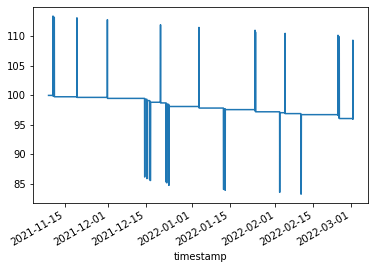

In [34]:
port.cash().plot()

In [35]:
port.stats()

Start                         2021-11-08 21:30:00+00:00
End                           2022-03-01 16:45:00+00:00
Period                                 79 days 16:30:00
Start Value                                       100.0
End Value                                     95.972374
Total Return [%]                              -4.027626
Benchmark Return [%]                          -1.837251
Max Gross Exposure [%]                        14.071301
Total Fees Paid                                2.146314
Max Drawdown [%]                               4.027626
Max Drawdown Duration                  78 days 01:45:00
Total Trades                                         32
Total Closed Trades                                  32
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                        0.0
Best Trade [%]                                -0.656845
Worst Trade [%]                               -1

In [67]:
overB = 95
overS = 5
ema_list = [200] # list(range(100,210, 10))
rsi_list = list(range(10, 20+1))
atr_list = list(range(10, 20+1))
params_list = []

for ema in ema_list:
    for rsi in rsi_list:
        for atr in atr_list:
            for i in range(40):
                params_list.append([ema, rsi, atr, overB-i, overS+i, 1.5])
# params_list[5:10]
len(params_list)

4840

In [68]:
good_params = {'win': 0, 'info': ''}
start = 0
end = 4840
win_start = 0

loop_num = start
for param in params_list[start:end]:
    result = backtest_rsi_o2(df, ema_len=param[0], rsi_len=param[1], atr_len=param[2], overbought=param[3], oversold=param[4], rr=param[5])
    if result['win_rate'] > win_start and result['total_order'] > 30:
        win_start = result['win_rate']
        good_params['win'] = result['win_rate']
        good_params['info'] = result['info']
    loop_num = loop_num + 1
    print(f"run: {loop_num} to {end}", end = "\r")
    
print(f"\nwin rate: {good_params['win']} %\n{good_params['info']}")

run: 4840 to 4840
win rate: 77.42 %
total orders: 31, overbought: 80, oversold: 20 ,rr: 1.5
ema: 200, rsi: 14, atr: 13, gain: 29.0



In [12]:
# EURUSD 1 pip = 0.0001
# GBPUSD 1 pip = 0.0001, xtb 1 pip value = 10 $
# USDJPY 1 pip = 0.01
# AUDUSD 1 pip = 0.0001
# 7.59 * 0.0001 == 0.000759
# lot_size or volume = target_profit / (((entry - exits) / pip ) * pip_value )
0.000759 / 0.01

0.0759

run: 1 to 2000
* win rate: 67.38 %
* total orders: 233, overbought: 71, oversold: 29 ,rr: 1.5
* ema: 200, rsi: 11, atr: 11, gain: 157.0

run: 2000 to 4000
* win rate: 66.67 %
* total orders: 159, overbought: 71, oversold: 29 ,rr: 1.5
* ema: 200, rsi: 15, atr: 19, gain: 106.0

run: 4000 to 4840
* win rate: 64.29 %
* total orders: 56, overbought: 73, oversold: 27 ,rr: 1.5
* ema: 200, rsi: 20, atr: 10, gain: 34.0

In [20]:
win_rate = 75.61
total_orders = 41
rr = 1.5
win_orders = int((win_rate * total_orders) / 100 )
loss_orders = total_orders - win_orders
gain = (win_orders * rr) - loss_orders
gain

36.5

#### The best params for EURUSD 15m

* win rate: 85.71 %
* total orders: 35, overbought: 74, oversold: 26 ,rr: 1.5
* ema: 200, rsi: 20, atr: 13
* gain: 37.5

#### The best params for GBPUSD 15m

* win rate: 72.5 %
* total orders: 40, overbought: 74, oversold: 26 ,rr: 1.5
* ema: 200, rsi: 19, atr: 14
* gain: 32.5

#### The best params for USDJPY 15m
* win rate: 77.42 %
* total orders: 31, overbought: 80, oversold: 20 ,rr: 1.5
* ema: 200, rsi: 14, atr: 13, 
* gain: 29.0

#### The best params for AUDUSD 15m

* win rate: 67.38 %
* total orders: 233, overbought: 71, oversold: 29 ,rr: 1.5
* ema: 200, rsi: 11, atr: 11 
* gain: 157.0